In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import erf, sqrt

def phi(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

In [3]:
def get_signal_vals(sigma_r, delta_x, A, B, lam, size=1):
    if A + B > 1:
        raise ValueError("A + B must be less than or equal to 1.")
    signal_vals = np.zeros(size)
    # Generate random numbers from 0 to 1 to determine which bias peak to sample from
    bias_rand_vals = np.random.rand(size)
    # For elements of bias_rand_vals less than A, sample from central Gaussian
    first_peak_indices = np.where(bias_rand_vals < A)[0]
    signal_vals[first_peak_indices] = np.random.normal(loc=0, scale=sigma_r, size=len(first_peak_indices))
    # For elements between A and A+B, sample from first shifted Gaussian
    second_peak_indices = np.where((bias_rand_vals >= A) & (bias_rand_vals < A + B))[0]
    signal_vals[second_peak_indices] = np.random.normal(loc=delta_x, scale=sigma_r, size=len(second_peak_indices))
    # For elements greater than A+B, sample from second shifted Gaussian
    third_peak_indices = np.where(bias_rand_vals >= A + B)[0]
    signal_vals[third_peak_indices] = np.random.normal(loc=-delta_x, scale=sigma_r, size=len(third_peak_indices))
    # Add lam Poisson-distributed noise
    signal_vals += np.random.poisson(lam, size)
    return signal_vals, second_peak_indices, third_peak_indices

def correct_signal_vals(signal_vals, delta_x, lam, q, true_high_indices=None, true_low_indices=None, mu=0):
    corrected_vals = signal_vals.copy()
    # Check for points between lam + delta_x - q and lam + delta_x + q
    # high_indices = np.where(signal_vals > lam + q)[0]
    # low_indices = np.where(signal_vals < lam - q)[0]
    high_indices = np.where((signal_vals > mu + lam + q) & (signal_vals < mu + lam + delta_x + q))[0]
    low_indices = np.where((signal_vals < mu + lam - q) & (signal_vals > mu + lam - delta_x - q))[0]
    corrected_vals[high_indices] -= delta_x
    corrected_vals[low_indices] += delta_x
    frac_corrected = (len(high_indices) + len(low_indices)) / len(signal_vals)
    # If true indices are provided, check precision and recall
    if true_high_indices is not None and true_low_indices is not None:
        # Check overlap between high_indices and true_high_indices
        true_positives_high = np.intersect1d(high_indices, true_high_indices)
        false_positives_high = len(high_indices) - len(true_positives_high)
        false_negatives_high = len(true_high_indices) - len(true_positives_high)
        # false_positive_rate = false_positives_high / len(corrected_vals)
        precision_high = len(true_positives_high) / (len(true_positives_high) + false_positives_high)
        recall_high = len(true_positives_high) / (len(true_positives_high) + false_negatives_high)
        # print(f"High Peak Correction - Precision: {precision_high:.3f}, Recall: {recall_high:.3f}")

    return corrected_vals, precision_high, recall_high, frac_corrected

In [4]:
def pr_z_gtr_z0(z0, lam, mu, sigma_r):
    result = 0
    for y in range(math.ceil(lam * 5)):
        if y > lam and (lam ** y) / math.factorial(y) < 1e-10:
            break
        prefactor = lam ** y * np.exp(-lam) / math.factorial(y)
        argument = 1 - phi((z0 - y - mu) / sigma_r)
        result += prefactor * argument
    return result

def false_pos_high(A, B, lam, q, sigma_r, delta_x):
    term_1 = A * pr_z_gtr_z0(lam + q, lam, 0, sigma_r) - A * pr_z_gtr_z0(lam + delta_x + q, lam, 0, sigma_r)
    term_2 = B * pr_z_gtr_z0(lam + q, lam, -delta_x, sigma_r) - B * pr_z_gtr_z0(lam + delta_x + q, lam, -delta_x, sigma_r)
    false_positive_prob = (term_1 + term_2) / (A + B)
    return false_positive_prob

def false_neg_high(A, B, lam, q, sigma_r, delta_x):
    numerator = (1 - A - B) * (1 - pr_z_gtr_z0(lam + q, lam, delta_x, sigma_r) + pr_z_gtr_z0(lam + delta_x + q, lam, delta_x, sigma_r))
    denominator_term_mid = A * (1 - pr_z_gtr_z0(lam + q, lam, 0, sigma_r) + pr_z_gtr_z0(lam + delta_x + q, lam, 0, sigma_r))
    denominator_term_low = B * (1 - pr_z_gtr_z0(lam + q, lam, -delta_x, sigma_r) + pr_z_gtr_z0(lam + delta_x + q, lam, -delta_x, sigma_r))
    denominator_term_high = numerator
    false_negative_prob = numerator / (denominator_term_mid + denominator_term_low + denominator_term_high)
    return false_negative_prob

def precision_high(A, B, lam, q, sigma_r, delta_x):
    false_pos = false_pos_high(A, B, lam, q, sigma_r, delta_x)
    pr_term_mid = A * pr_z_gtr_z0(lam + q, lam, 0, sigma_r) - A * pr_z_gtr_z0(lam + delta_x + q, lam, 0, sigma_r)
    pr_term_low = B * pr_z_gtr_z0(lam + q, lam, -delta_x, sigma_r) - B * pr_z_gtr_z0(lam + delta_x + q, lam, -delta_x, sigma_r)
    pr_term_high = (1 - A - B) * pr_z_gtr_z0(lam + q, lam, delta_x, sigma_r) - (1 - A - B) * pr_z_gtr_z0(lam + delta_x + q, lam, delta_x, sigma_r)
    tot_pos = pr_term_mid + pr_term_low + pr_term_high
    precision = (tot_pos - false_pos) / tot_pos
    return precision

def recall_high(A, B, lam, q, sigma_r, delta_x):
    recall = pr_z_gtr_z0(lam + q, lam, delta_x, sigma_r)
    return recall

Maximum lam is 1.04
0.9888102788497405
0.474977963972739
0.988843954818017 0.4727963728497133 0.14894


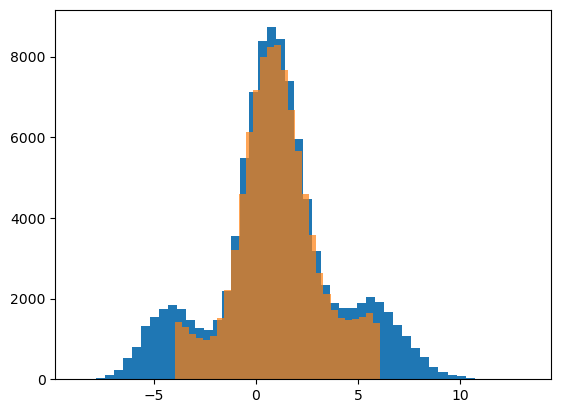

In [7]:
sigma_r = 1
delta_x = 5
A = 0.7
B = (1 - A) / 2
q_factor = 3.5
lam_max = (delta_x / q_factor) ** 2 - sigma_r**2
lam = lam_max
q = q_factor * np.sqrt(lam + sigma_r**2)
print(f"Maximum lam is {lam_max:.2f}")
print(precision_high(A, B, lam, q, sigma_r, delta_x))
print(recall_high(A, B, lam, q, sigma_r, delta_x))
signal_vals, true_high, true_low = get_signal_vals(sigma_r, delta_x, A, B, lam, size=100000)
corrected_vals, precision_high_mc, recall_high_mc, frac_corrected = correct_signal_vals(signal_vals, delta_x, lam, q, true_high_indices=true_high, true_low_indices=true_low)
print(precision_high_mc, recall_high_mc, frac_corrected)
plt.hist(signal_vals, bins=50)
plt.hist(corrected_vals, bins=50, alpha=0.7)
plt.show()

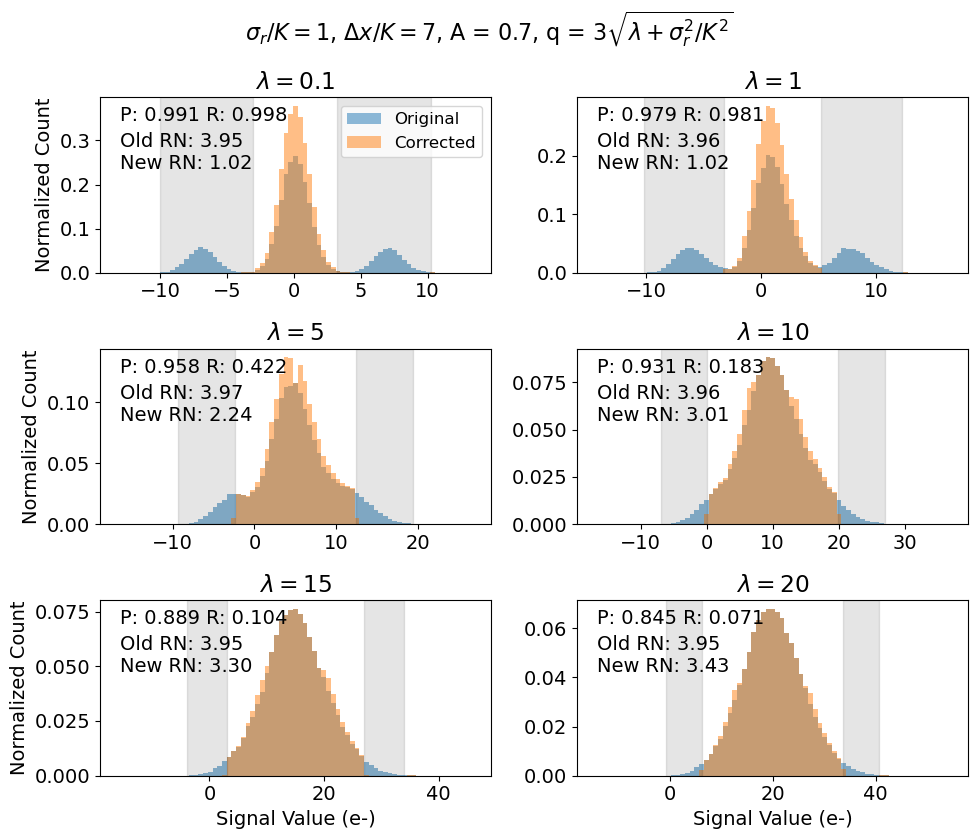

In [328]:
# Make all fontsize 14
plt.rcParams.update({'font.size': 14})
# Make the same plot again but for 4 values of lambda. I want a figure with 4 subplots.
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
lambda_values = [0.1, 1, 5, 10, 15, 20]
for i, lam in enumerate(lambda_values):
    signal_vals, true_high, true_low = get_signal_vals(sigma_r, delta_x, A, B, lam, size=100000)
    q = 3 * np.sqrt(lam + sigma_r**2)
    corrected_vals, precision_high_mc, recall_high_mc, frac_corrected = correct_signal_vals(signal_vals, delta_x, lam, q, true_high_indices=true_high, true_low_indices=true_low)
    ax = axs[i // 2, i % 2]
    # Normalized histograms
    ax.hist(signal_vals, bins=75, range=(lam-delta_x-2*q, lam+delta_x+2*q), alpha=0.5, label='Original', density=True)
    ax.hist(corrected_vals, bins=75, range=(lam-delta_x-2*q, lam+delta_x+2*q), alpha=0.5, label='Corrected', density=True)
    ax.set_title(r'$\lambda = $' + str(lam))
    # Display precision and recall in the subplot
    ax.text(0.05, 0.95, f'P: {precision_high_mc:.3f} R: {recall_high_mc:.3f}',
            transform=ax.transAxes, verticalalignment='top')
    # Calculate old and corrected read noise
    old_rn = np.sqrt(np.var(signal_vals) - lam)
    new_rn = np.sqrt(np.var(corrected_vals) - lam)
    old_tot_std = np.sqrt(np.var(signal_vals))
    new_tot_std = np.sqrt(np.var(corrected_vals))
    perfect_std = np.sqrt(sigma_r**2 + lam)
    ax.text(0.05, 0.80, f'Old RN: {old_rn:.2f}\nNew RN: {new_rn:.2f}',
            transform=ax.transAxes, verticalalignment='top')
    # Make shaded bands where corrections are made
    ax.axvspan(lam + q, lam + delta_x + q, color='k', alpha=0.1)
    ax.axvspan(lam - delta_x - q, lam - q, color='k', alpha=0.1)
    if i == 0:
        # Put legend below suptitle, in one row
        ax.legend(fontsize=12)
    if i // 2 == 2:
        ax.set_xlabel('Signal Value (e-)')
    if i % 2 == 0:
        ax.set_ylabel('Normalized Count')
plt.tight_layout()
plt.suptitle(r'$\sigma_r/K = $' + str(sigma_r) + r', $\Delta x/K = $' + str(delta_x) + ', A = ' + str(A) + r', q = 3$\sqrt{\lambda + \sigma_r^2/K^2}$', y=1.05, fontsize=16)
plt.show()